In [1]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
from torchsummary import summary
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt 
from IPython import display

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
PATH = './'
CODE_SIZE = 256
BATCH_SIZE = 32
IMG_SIZE = 3
BIAS = True

cuda:0


In [3]:
(x,y) , (_,_) = cifar10.load_data()

In [4]:
# NUM_CLASSES = 10
# cifar10_classes = {"airplane":0, "automobile":1, "bird":2, "cat":3, "deer":4, 
#                    "dog":5, "frog":6, "horse":7, "ship":8, "truck":9}
# generate_class = "automobile"

# class_num = cifar10_classes[generate_class]
# class_indices = np.where(y == class_num)[0]
# x = x[class_indices,:,:,:]

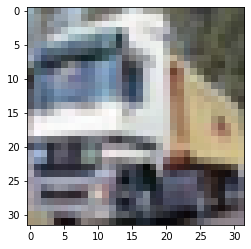

In [5]:
plt.imshow(x[1,:,:,:])

In [6]:
x = np.moveaxis(x,3,1)
x = x.astype(np.float32)
print('Data shape: ', x.shape)
x = (x/255.) 
IMG_SHAPE = x[0,:,:,:].shape

Data shape:  (50000, 3, 32, 32)


In [7]:
class discriminator(torch.nn.Module):
    def __init__(self,nchannels, BIAS):
        super(discriminator ,self).__init__()
        self.main = nn.Sequential(
            
        nn.Conv2d(in_channels=nchannels, out_channels=16, kernel_size=3, stride=1, padding=1, bias=BIAS),
        nn.ELU(),
            
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=BIAS),
        nn.ELU(),
        nn.AvgPool2d(kernel_size=2),
        
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=BIAS),
        nn.ELU(),        
        
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=BIAS),
        nn.ELU(),
        nn.AvgPool2d(kernel_size=2),
        
        nn.Flatten(),
        
        nn.Linear( in_features = 4096 , out_features = 256, bias=BIAS),    
        nn.Tanh(),
        
        nn.Linear( in_features = 256 , out_features = 2, bias=BIAS),
        torch.nn.LogSoftmax()
        )
    
    def forward(self,X):
        return self.main(X)
               

In [8]:
class Reshape(nn.Module):
    def __init__(self, shape, batch_size=32):
        super(Reshape ,self).__init__()
        self.shape = shape
        self.batch_size = batch_size

    def forward(self, x):
        return x.view([x.size()[0], self.shape[0], self.shape[1], self.shape[2] ])
    

class generator(torch.nn.Module):
    def __init__(self,code_size, BIAS):
        super(generator ,self).__init__()
        
        self.main = nn.Sequential(
    
        nn.Linear(code_size, 640),
        Reshape((10,8,8)),
            
        torch.nn.ConvTranspose2d(in_channels=10, out_channels=64, kernel_size=5, stride=1, padding=0, bias=BIAS),
        nn.ELU(),
        
        torch.nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=0, bias=BIAS),
        nn.ELU(),
        torch.nn.Upsample(scale_factor=2),
        
        torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0, bias=BIAS),
        nn.ELU(),
        
        torch.nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0, bias=BIAS),
        nn.ELU(),
        
        torch.nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0, bias=BIAS),
        nn.ELU(),
        
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0, bias=BIAS),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0, bias=BIAS),
        nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=0, bias=BIAS)
        )
        
    def forward(self, x):
        return self.main(x)

In [9]:

disc = discriminator( IMG_SIZE, BIAS ).to(device)
gen = generator( CODE_SIZE, BIAS ).to(device)
summary(disc, IMG_SHAPE, batch_size=-1, device='cuda')
summary(gen, (1,256), batch_size=-1, device='cuda')

E:\Programs\Miniconda\envs\py36\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
               ELU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           4,640
               ELU-4           [-1, 32, 32, 32]               0
         AvgPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 32, 16, 16]           9,248
               ELU-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
               ELU-9           [-1, 64, 16, 16]               0
        AvgPool2d-10             [-1, 64, 8, 8]               0
          Flatten-11                 [-1, 4096]               0
           Linear-12                  [-1, 256]       1,048,832
             Tanh-13                  [-1, 256]               0
           Linear-14                   

In [10]:
def sample_images(nrow=2,ncol=2):
    
    with torch.no_grad():
        images = gen(torch.randn( (nrow*ncol, CODE_SIZE), dtype = torch.float32, device = device)).cpu().numpy()
    images = np.moveaxis(images,1,3)
    
    if np.var(images)!=0:
        images = images.clip(np.min(x),np.max(x))
    
    print('Sampled images:')
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        plt.imshow(images[i,:,:,:],cmap="gray")
    plt.show()

def sample_probas(bsize):
    idx = np.random.choice(np.arange(x.shape[0]), size=bsize)
    with torch.no_grad():
        D_G_z = np.exp(disc(gen(torch.randn( (bsize, CODE_SIZE), dtype = torch.float32, device = device))).cpu().numpy()[:,1])
        D_x = np.exp(disc(torch.Tensor(x[idx]).to(device)).cpu().numpy()[:,1])
        
    plt.title('Generated vs real data')
    plt.hist(D_x,
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(D_G_z,
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()
        

In [11]:
b1 = 0.9
optimizerD = torch.optim.Adam(disc.parameters(), lr=1e-3, betas=(b1, 0.999))
optimizerG = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=(b1, 0.999))
EPOCHS = 3000
DISC_ITER = 5
GEN_ITER = 1

Sampled images:


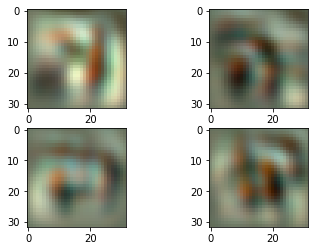

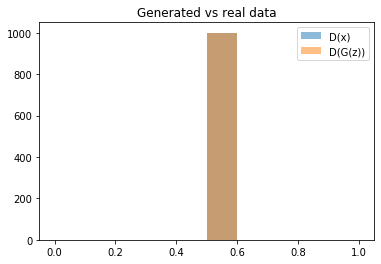

Current epoch:  2950
Discriminator real data error:  0.7453711032867432
Discriminator fake data error:  0.6931754946708679
Discriminator total error:  1.438546597957611
Generator error:  0.6930505037307739


In [12]:
for epoch in range(EPOCHS):
    
    for i in range(DISC_ITER):
        dderror=0
        dgerror=0
        idx = np.random.choice(np.arange(x.shape[0]), size=100)
        optimizerD.zero_grad()
        D_x = disc(torch.Tensor(x[idx,:,:,:]).to(device))
        logp_real = -1*torch.mean(D_x[:,1]) +torch.mean(disc.main[-2]._parameters['weight'].data**2)+torch.mean(disc.main[-2]._parameters['bias'].data**2)
        logp_real.backward()
    
        
        code = torch.randn( (100, CODE_SIZE), dtype = torch.float32, device = device)
        fake_img = gen(code).detach()
        D_G_z = disc(fake_img.detach())
        logp_gen = -1*torch.mean(D_G_z[:,0])
        logp_gen.backward()
        errD = (logp_gen + logp_real)
        optimizerD.step()
        dderror += logp_real.item()
        dgerror += logp_gen.item()
        
        
    for j in range(GEN_ITER):        
        code = torch.randn( (100, CODE_SIZE), dtype = torch.float32, device = device)
        gerror = 0
        optimizerG.zero_grad()
        fake_img = gen(code)
        D_G_z = disc(fake_img)
        logp_gen = -1*torch.mean(D_G_z[:,1])
        logp_gen.backward()
        optimizerG.step()
        gerror += logp_gen.item()
    
        
    
    if epoch%50 == 0:
        display.clear_output(wait=True)
        idx = np.random.choice(np.arange(x.shape[0]), size=1000)
        sample_images()
        sample_probas(1000)
        print('Current epoch: ', epoch)
        print('Discriminator real data error: ', dderror)
        print('Discriminator fake data error: ', dgerror)
        print('Discriminator total error: ', dderror + dgerror)
        print('Generator error: ', gerror)
        
        
        

In [ ]:
torch.save(disc.state_dict(), PATH + '/My_Discriminator.pth')
torch.save(gen.state_dict(), PATH + '/My_Generator.pth')

In [ ]:
gen = generator(CODE_SIZE,BIAS).to(device)
gen.load_state_dict(torch.load(PATH + '/My_Generator.pth'))

In [ ]:
IMG_SHAPE = (36,36,3)
sample_images(2,2)